# Baron et al - scRNA-seq on mouse pancreatic islets - INGAP project

See [tutorial](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb)

In [ ]:
!pip install -q scanpy
!pip install -q MulticoreTSNE
!pip install -q mnnpy
!pip install -q gseapy
#from google.colab import drive
#drive.mount('/content/gdrive')
#pip freeze local > /content/gdrive/My\ Drive/colab_installed.txt

     |████████████████████████████████| 7.2MB 2.6MB/s 
     |████████████████████████████████| 122kB 51.2MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 532kB 2.8MB/s 
     |████████████████████████████████| 215kB 12.9MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 153kB 13.8MB/s 
     |████████████████████████████████| 5.2MB 14.6MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 235kB 43.8MB/s 


In [ ]:
from itertools import chain
%pylab inline
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as pl
from matplotlib import rcParams
import re
import csv
import MulticoreTSNE
import mnnpy

import gseapy as gp

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
# https://github.com/satijalab/seurat/issues/723

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7f89e839c1e0>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsu

Creating directory /root/.config/bioservices 
scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.22.2.post1 statsmodels==0.10.2


### Import Baron et al data from .csv file

In [ ]:
filename = '/GSM2230761_ALL_mouse_umifm_counts_no_cell_type.csv'
adata_file = sc.read_csv(filename, delimiter=',', first_column_names=True, dtype='str')

# adata_Baron = sc.AnnData(X=adata_file.raw.X, var=adata_file.raw.var, obs=adata_file.obs)
# adata_ss2.raw = adata_ss2


FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
adata_file

AnnData object with n_obs × n_vars = 1886 × 14878 

In [ ]:
adata_Baron = sc.AnnData(X=adata_file)

In [ ]:
adata_Baron.obs_names

Index(['mouse1_lib1.final_cell_0001', 'mouse1_lib1.final_cell_0002',
       'mouse1_lib1.final_cell_0003', 'mouse1_lib1.final_cell_0004',
       'mouse1_lib1.final_cell_0005', 'mouse1_lib1.final_cell_0006',
       'mouse1_lib1.final_cell_0007', 'mouse1_lib1.final_cell_0008',
       'mouse1_lib1.final_cell_0009', 'mouse1_lib1.final_cell_0010',
       ...
       'mouse2_lib3.final_cell_0386', 'mouse2_lib3.final_cell_0387',
       'mouse2_lib3.final_cell_0388', 'mouse2_lib3.final_cell_0389',
       'mouse2_lib3.final_cell_0390', 'mouse2_lib3.final_cell_0391',
       'mouse2_lib3.final_cell_0392', 'mouse2_lib3.final_cell_0393',
       'mouse2_lib3.final_cell_0394', 'mouse2_lib3.final_cell_0395'],
      dtype='object', length=1886)

In [ ]:
adata_Baron.var_names

Index(['0610007P14Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610009O20Rik', '0610010F05Rik', '0610010K14Rik', '0610011F06Rik',
       '0610012G03Rik', '0610025J13Rik',
       ...
       'Zw10', 'Zwilch', 'Zwint', 'Zxdb', 'Zxdc', 'Zyg11b', 'Zyx', 'Zzef1',
       'Zzz3', 'l7Rn6'],
      dtype='object', length=14878)

# Add assigned cell type observation

In [ ]:
shape(adata_Baron)

(1886, 14878)

In [ ]:
filename2 = '/media/santi/Data_Analysis/B_Integrative_Analyses/00_INGAP_Project/H_scRNAseq/Baron_et_al/GSM2230761_ALL_mouse_umifm_counts.csv'
anno = pd.read_csv(filename2, index_col=0)

In [ ]:
shape(anno)

(1886, 14879)

In [ ]:
adata_Baron.obs['cell_type'] = anno['assigned_cluster']
# adata_file.obs['cell_type'] = 0


# NOW START THE ANALYSIS!!!

# IDENTIFY CLUSTER MARKER GENES

In [ ]:
# Finding marker genes
sc.tl.rank_genes_groups(adata_Baron, 'cell_type', method='wilcoxon')

# As an alternative, let us rank genes using logistic regression.
# For instance, this has been suggested by Natranos et al. (2018).
# sc.tl.rank_genes_groups(adata_ss2_no_d6, 'louvain', method='logreg', solver='saga', multi_class='auto')

# sc.pl.rank_genes_groups(adata_ss2_no_d6, n_genes=10, sharey=False, fontsize=12)
pd.DataFrame(adata_Baron.uns['rank_genes_groups']['names']).head(20)

ranking genes


... storing 'cell_type' as categorical


    finished (0:00:02.41) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


B_cell   T_cell activated_stellate   alpha    beta    delta   ductal  \
0    Coro1a    Trbc2           Serpinh1     Gcg    Ins2      Sst     Krt8   
1      Ighm     Trac                Vim     Ttr    Ins1      Pyy      Clu   
2      Cd74      Spn              Sparc    Gpx3  Prss53     Rbp4    Krt18   
3    Shisa5    Ptprc              Cald1    Gnas    Iapp     Hhex    Cldn4   
4       B2m    Celf2             Col1a1  Pcsk1n   G6pc2    Cd24a  Zfp36l1   
5     Iglc3   Laptm5               Il11   Aplp1  Ero1lb      Ppy     Flna   
6      Igkc    H2-D1             Col4a1  Tmem27    Scg3     Gpx3     Cd44   
7     Cd79a     Ets1             Ifitm3  Resp18    Chga     Chgb    Anxa3   
8      Rac2     Srgn              Fstl1   Pcsk2    Prlr    Sez6l     Dsg2   
9      Cd52      B2m                Il6    Rbp4   Bace2    Abcc8     Sox4   
10    Rps11   Shisa5             Col5a2    Cst3   Igf1r     Arg1     Nfib   
11    Ptprc     Cd3d             Igfbp7      Gc  Papss2  Fam159b     Cdh1   
12   H2-Ab1    Il2rb               Sdc1     Pyy    Scg2     Isl1    Anxa2   
13   H2-Eb1      Lck             Lgals1     Cpe  Atp2a2     Dpp6   S100a6   
14  Arhgdib    Pdcd1                Msn    Mafb    Syt4     Mest    Cldn3   
15    H2-Aa   sep-01               Tpm4    Scg5  Nkx6-1      Clu   Myl12a   
16    Rps20  Ptprcap                Dcn  Eef1a2    Acly    Auts2  Onecut2   
17   Rpl18a      Ltb             Col3a1    Ctsz   Gsdma     Ache    Actn1   
18    Rps24    Dock2             Col5a1    Irx1  Spock2   Resp18     Ier3   
19    Iglc2     Cd53                Tnc     Lpl   Ptprn     Gnas   Fermt1   

   endothelial          gamma immune_other macrophage quiescent_stellate  \
0       Pecam1            Ppy         Ccr7       Ctss            Gm13889   
1        Egfl7            Pyy       Tbc1d4     Laptm5              Ednrb   
2         Cdh5           Ace2        Cytip     Pla2g7             Igfbp5   
3         Flt1        Ugt2b34        Il4i1       Fth1               Rgs5   
4        Sparc         Tmem27        Traf1       Apoe              S1pr3   
5        Plvap             Gc      Tmem123       Cd74                Vim   
6       Col4a2         Tspan8       Tmsb4x       Npc2             Ptp4a3   
7       Col4a1           Gpx3        Fscn1       Ftl1             Col4a1   
8        S1pr1           Scg5         Ccl5     Lgals3               Smtn   
9          Eng           Wnt4       Syngr2     Fcer1g           Ndufa4l2   
10     Serinc3           Etv1        Ramp3        B2m                Ngf   
11        Esam           Scgn         Cnn2       C1qa                Mgp   
12        Tcf4            Arx         Etv3     Tyrobp             Sema6d   
13        Cd93  5330417C22Rik         Cd74       Ctsb           Serpinh1   
14      Sema7a           Cst3       Marcks       Psap             Col4a2   
15         Kdr         Resp18        H2-Q7       C1qb               Ldha   
16         Msn           Ptms         Actb      H2-Aa              Epas1   
17        Esm1          Aplp1        Calm1     Tmsb4x                Msn   
18         B2m          Abcc8          B2m       Lyz2               Stc1   
19        Emcn          Folr1        Adcy6       Srgn              Cald1   

     schwann  
0        Nes  
1        Vim  
2       Nkd2  
3       Gpc1  
4     Col5a2  
5        Btc  
6     Arpc1b  
7       Gas7  
8    Fam19a5  
9      Metrn  
10       Msn  
11      Zeb2  
12    Pmepa1  
13  Sh3pxd2b  
14      Emp3  
15     Cryab  
16   Hnrnpa1  
17     Rpl13  
18    Gm9844  
19    Eif4a1

In [ ]:
markers = pd.DataFrame(adata_Baron.uns['rank_genes_groups']['names'])

deg_list = list(np.asarray(markers))

for x in range (13):
    markers[x] = [row[x] for row in deg_list]

In [ ]:
with open('00_Baron_markers_B_cell.txt', 'w') as f:
    for item in markers[0]:
        f.write("%s\n" % item)

with open('01_Baron_markers_T_cell.txt', 'w') as f:
    for item in markers[1]:
        f.write("%s\n" % item)

with open('02_Baron_markers_act_stellate.txt', 'w') as f:
    for item in markers[2]:
        f.write("%s\n" % item)

with open('03_Baron_markers_alpha.txt', 'w') as f:
    for item in markers[3]:
        f.write("%s\n" % item)

with open('04_Baron_markers_beta.txt', 'w') as f:
    for item in markers[4]:
        f.write("%s\n" % item)

with open('05_Baron_markers_delta.txt', 'w') as f:
    for item in markers[5]:
        f.write("%s\n" % item)

with open('06_Baron_markers_ductal.txt', 'w') as f:
    for item in markers[6]:
        f.write("%s\n" % item)

with open('07_Baron_markers_endothelial.txt', 'w') as f:
    for item in markers[7]:
        f.write("%s\n" % item)

with open('08_Baron_markers_gamma.txt', 'w') as f:
    for item in markers[8]:
        f.write("%s\n" % item)

with open('09_Baron_markers_immune_other.txt', 'w') as f:
    for item in markers[9]:
        f.write("%s\n" % item)

with open('10_Baron_markers_macrophage.txt', 'w') as f:
    for item in markers[10]:
        f.write("%s\n" % item)

with open('11_Baron_markers_quiescent_stellate.txt', 'w') as f:
    for item in markers[11]:
        f.write("%s\n" % item)

with open('12_Baron_markers_schwann.txt', 'w') as f:
    for item in markers[12]:
        f.write("%s\n" % item)


In [ ]:
markers = pd.DataFrame(adata_Baron.uns['rank_genes_groups']['names']).head(4)
# note, ".T" is to transpose the numpy array and get the right order for cluster markers in the dotplot below
deg_list = list(np.asarray(markers).T)
flat_list = [item for sublist in deg_list for item in sublist]

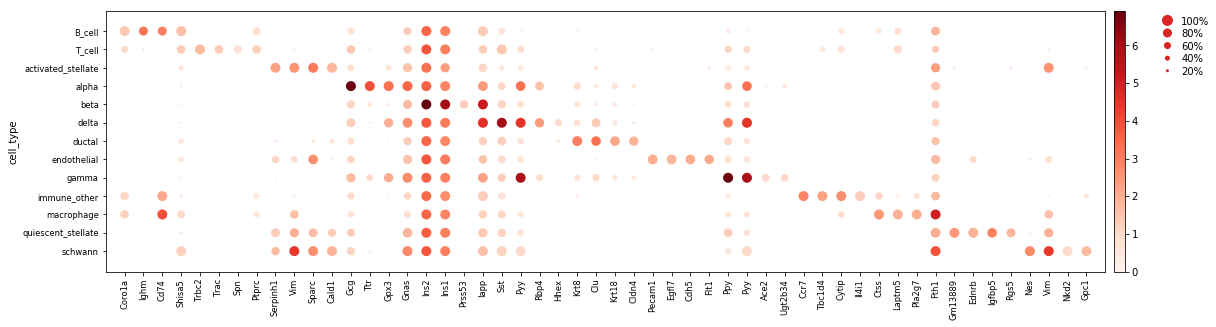

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[18.2, 0, 0.2, 0.5, 0.25])

In [ ]:
figsize(10,3)
sc.pl.dotplot(adata_Baron, flat_list, groupby='cell_type', log=True)

# Now check expression of INGAP regulated genes

saving figure to file ./figures/stacked_violinINGAP_markers.pdf


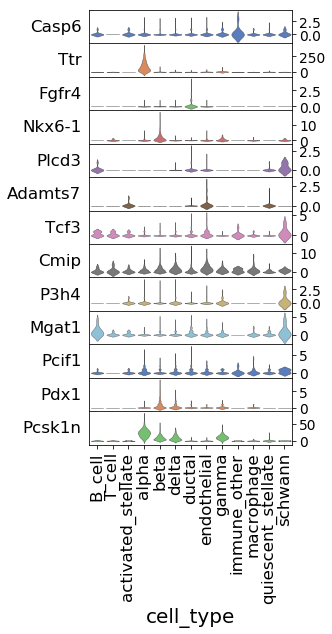

In [ ]:
# NOTE: we want to score INGAP regulated genes, in the following list, according to the
# predominant cell type in which each gene is most expressed

INGAP_markers = ['Msc', 'Plcd3', 'Casp6', 'Adamts7', 'P3h4', 'Tcf3', 'Pcif1', 'Ndts2', 'Hmmr', 'Mgat1',
                 'Pdx1', 'Fgfr4', 'Nkx6-1', 'Ttr', 'Cmip', 'Pcsk1n']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(adata_Baron.var_names) & set(INGAP_markers))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(4,8), save=('INGAP_markers'))



saving figure to file ./figures/stacked_violinINGAP_markers_Exp9_16.pdf


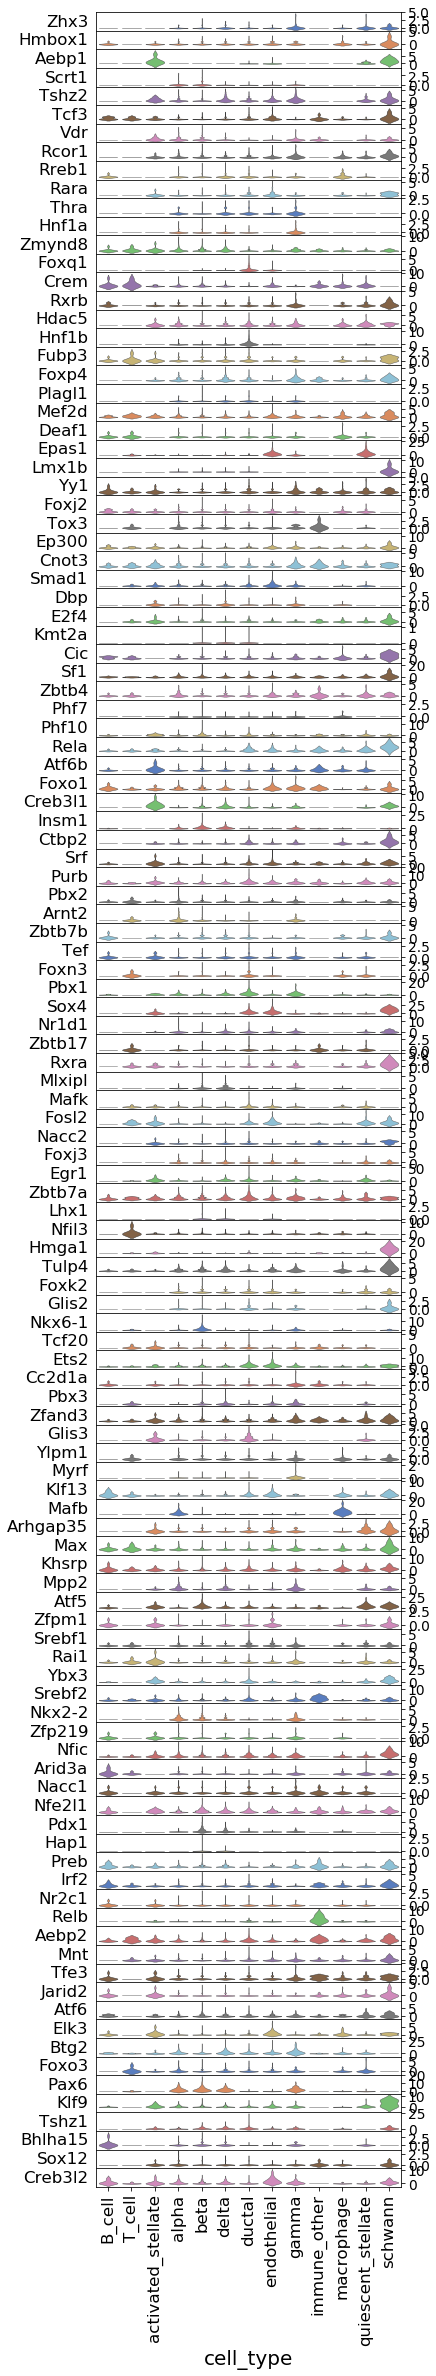

In [ ]:
# NOTE: we want to score INGAP regulated genes, in the following list, according to the
# predominant cell type in which each gene is most expressed

INGAP_markers = ['Irf2', 'Mafb', 'Scrt1', 'Tcf3', 'Glis2', 'Klf9', 'Mlxipl', 'Zbtb17', 'Egr1', 'Ctbp2', 'Phf7', 'Prdm2', 'Dbp', 'Cc2d1a', 'Hivep1', 'Nfic', 'Hmbox1', 'Glis3', 'Plagl1', 'Creb3l1', 'Klf13', 'Myrf', 'Cnot3', 'Mnt', 'Nacc1', 'Nr1d1', 'Mef2d', 'Rara', 'Thra', 'Mpp2', 'Tshz2', 'Ylpm1', 'Zfpm1', 'Zbtb7a', 'Bhlha15', 'Nkx6-1', 'Tshz1', 'Lmx1b', 'Atf6b', 'Epas1', 'Rreb1', 'Hmga1', 'Rxra', 'Srebf1', 'Creb3l2', 'Foxo3', 'Foxp4', 'Foxj2', 'Rai1', 'Foxj3', 'Sf1', 'Hap1', 'Khsrp', 'Tox3', 'Foxk2', 'Mafa', 'Arhgap35', 'Rela', 'Sox4', 'Nr2c1', 'Elk3', 'Nfil3', 'Zbtb4', 'Ybx3', 'Aebp2', 'Srebf2', 'Zfand3', 'Mypop', 'Arnt2', 'Tfe3', 'Rxrb', 'Sox12', 'Srf', 'Hnf1a', 'Aebp1', 'Nkx2-2', 'Cic', 'Jarid2', 'Ep300', 'E2f4', 'Zfp219', 'Tcf20', 'Purb', 'Tef', 'Hnf1b', 'Relb', 'Lhx1', 'Foxn3', 'Foxo1', 'Nacc2', 'Nfe2l1', 'Preb', 'Zbtb7b', 'Arid3a', 'Tp53', 'Max', 'Deaf1', 'Zmynd8', 'Ets2', 'Rcor1', 'Yy1', 'Hdac5', 'Vdr', 'Zhx3', 'Insm1', 'Phf10', 'Atf6', 'Pax6', 'Kmt2a', 'Tulp4', 'Fosl2', 'Pbx1', 'Mafk', 'Smad1', 'Atf5', 'Foxq1', 'Crem', 'Pbx3', 'Pbx2', 'Btg2', 'Fubp3', 'Pdx1']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(adata_Baron.var_names) & set(INGAP_markers))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,40), save=('INGAP_markers_Exp9_16'))




saving figure to file ./figures/stacked_violinINGAP_markers_Exp9_16_Rank_FC16.pdf


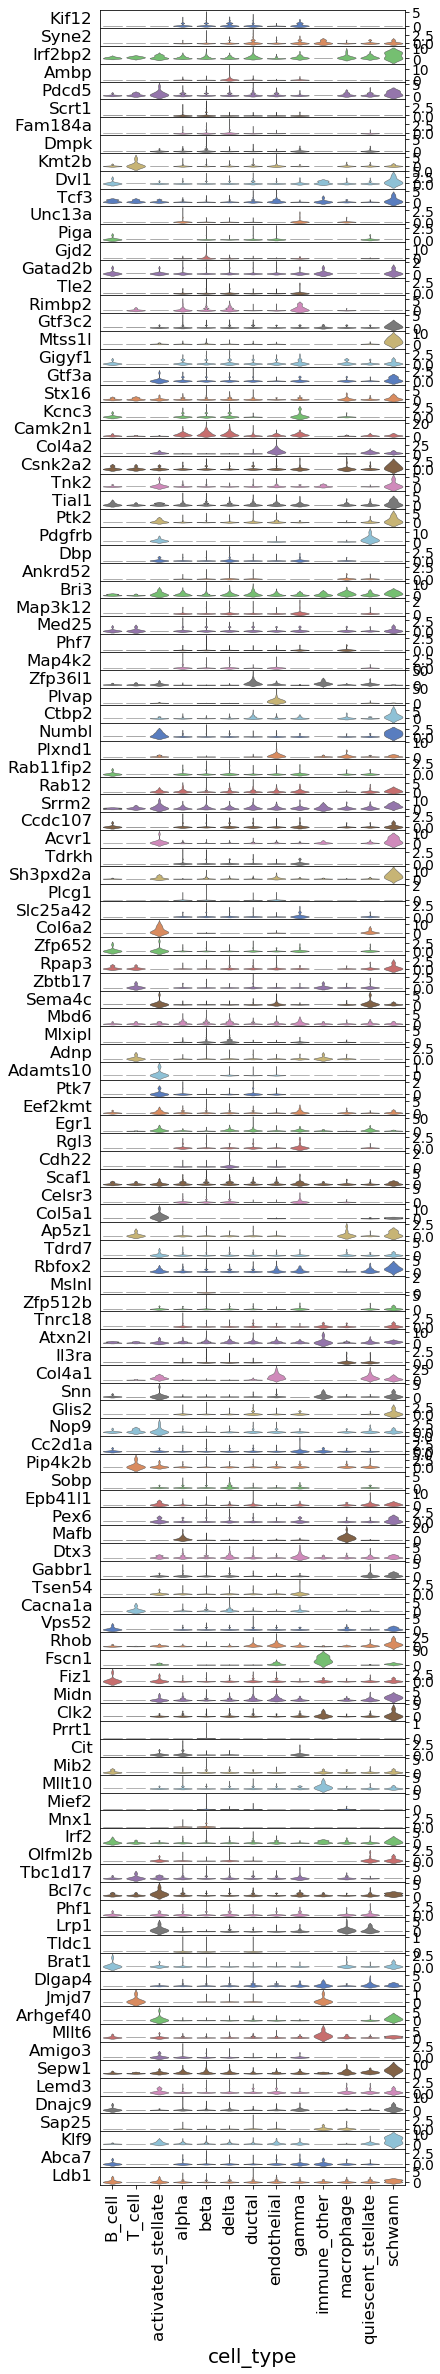

In [ ]:
# NOTE: we want to score INGAP regulated genes, in the following list, according to the
# predominant cell type in which each gene is most expressed

INGAP_markers = ['LOC100362339', 'Pdcd5', 'Mlxipl', 'Gtf3c2', 'Slc25a42', 'Syne2', 'Ambp', 'Eef2kmt', 'Zfp652', 'Plcg1', 'Fscn1', 'Plxnd1', 'Mbd6', 'Ptk2', 'Il3ra', 'Kif12', 'Adamts10', 'Rpap3', 'Zfp36l1', 'Gabbr1', 'Ap5z1', 'Sema4c', 'Celsr3', 'LOC103694875', 'Tle2', 'Gigyf1', 'Tnk2', 'Sobp', 'Zbtb17', 'Ctbp2', 'Tldc1', 'Kmt5c', 'Phf7', 'Tdrd7', 'Carmil3', 'Rimbp2', 'Rab11fip2', 'Cacna1a', 'LOC103690153', 'Col4a2', 'Rgl3', 'Map3k12', 'Map4k2', 'Egr1', 'Tial1', 'Epb41l1', 'Gjd2', 'Olfml2b', 'Kcnc3', 'RGD1564664', 'Myo9b', 'Sh3pxd2a', 'Ccdc107', 'Tnrc18', 'Atxn2l', 'Pip4k2b', 'Fiz1', 'Dbp', 'Dmpk', 'Zfp512b', 'Mafb', 'Brat1', 'Piga', 'Dtx3', 'Sepw1', 'Rab12', 'Glis2', 'Kmt2b', 'Tsen54', 'Prdm2', 'Pdgfrb', 'Jmjd7', 'Col4a1', 'Mtss1l', 'Rbfox2', 'Srrm2', 'Gtf3a', 'Bcl7c', 'Csnk2a2', 'Acvr1', 'Mllt10', 'Arhgef40', 'Tcf3', 'Spem1', 'Abca7', 'Fam184a', 'Numbl', 'Vps52', 'Cdh22', 'Camk2n1', 'Snn', 'Mllt6', 'Tdrkh', 'Ldb1', 'Scaf1', 'Scrt1', 'Dnajc9', 'Irf2bp2', 'Clk2', 'Rhob', 'Unc13a', 'Klf9', 'Col5a1', 'Myh9l1', 'Mief2', 'Gatad2b', 'Fbrs', 'Mslnl', 'Phf1', 'Amigo3', 'Med25', 'Mib2', 'Adnp', 'Sap25', 'Nop9', 'Midn', 'Tbc1d17', 'Dvl1', 'Plvap', 'Ankrd52', 'Cit', 'Irf2', 'Lrp1', 'Ptk7', 'Cc2d1a', 'Col6a2', 'Stx16', 'Bri3', 'Dlgap4', 'Lemd3', 'Mnx1', 'Pex6', 'Prrt1']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(adata_Baron.var_names) & set(INGAP_markers))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,40), save=('INGAP_markers_Exp9_16_Rank_FC16'))




saving figure to file ./figures/stacked_violinINGAP_markers_TF_Exp18.pdf


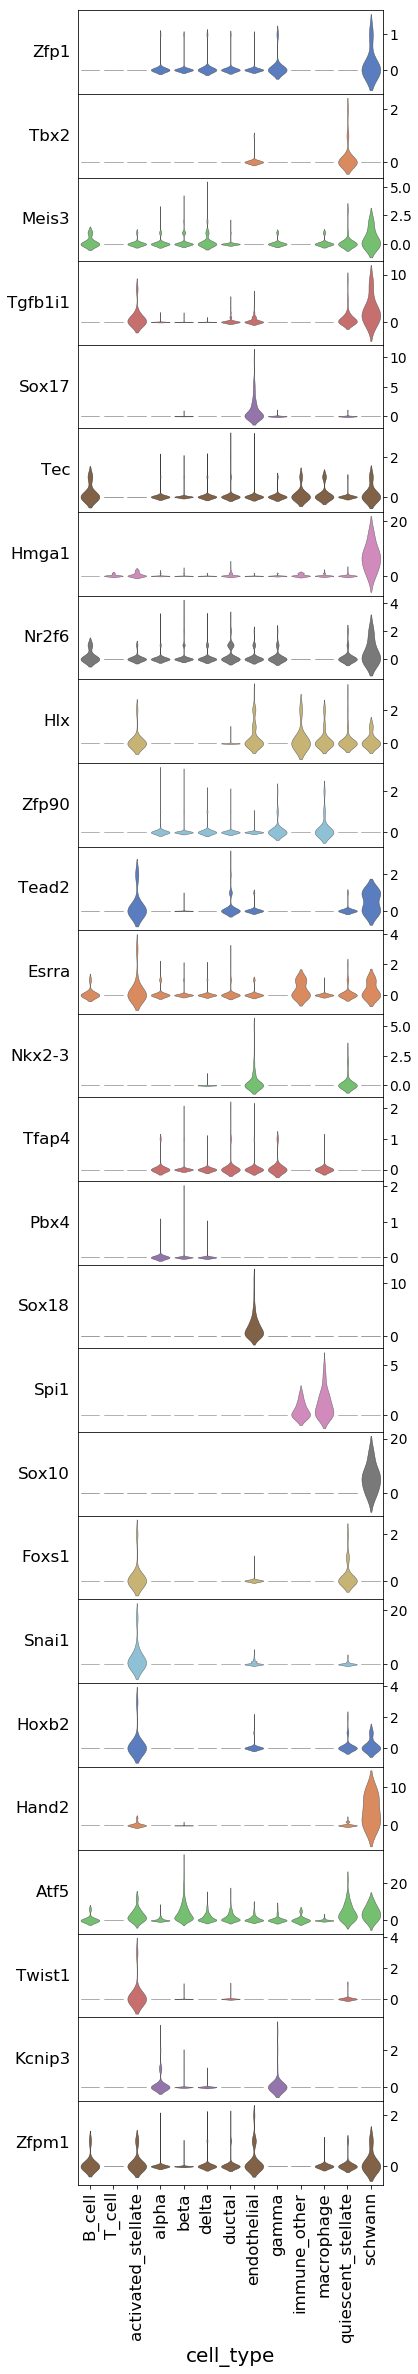

In [ ]:
# NOTE: we want to score INGAP regulated genes, in the following list, according to the
# predominant cell type in which each gene is most expressed

INGAP_markers = ['Pbx4', 'Prrx2', 'Zfp90', 'Foxs1', 'Dmp1', 'Hes2', 'Tbx2', 'Msc', 'Hoxb2', 'Hand2', 'Dlx5', 'Spi1', 'Tead2', 'Hlx', 'Zfp1', 'Tgfb1i1', 'Hmx1', 'Tfap4', 'Sox17', 'Snai1', 'Hmga1', 'Sox10', 'Atf5', 'Twist1', 'Esrra', 'Tec', 'Nkx2-3', 'Sox18', 'Kcnip3', 'Zfpm1', 'Meis3', 'Nr2f6']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(adata_Baron.var_names) & set(INGAP_markers))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,40), save=('INGAP_markers_TF_Exp18'))




saving figure to file ./figures/stacked_violinINGAP_POTENCIAL_CONTAMINATION_markers_ALL.pdf


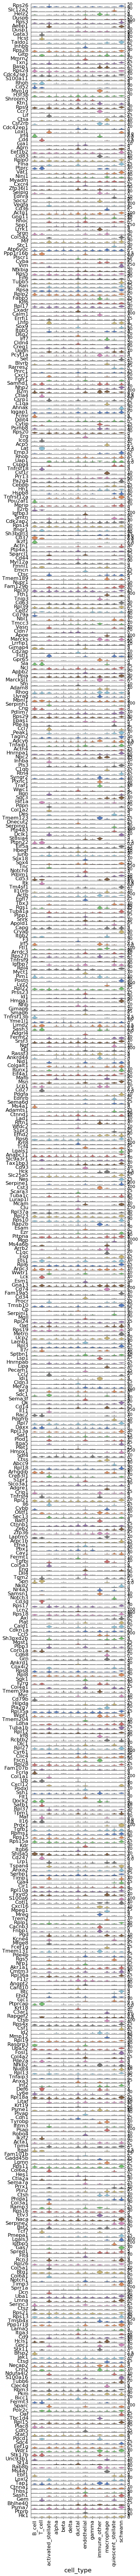

In [ ]:
# NOTE: we want to score INGAP regulated genes, in the following list, according to the
# predominant cell type in which each gene is most expressed

INGAP_markers = ['Irf4', 'Hmga1', 'Sox18', 'Tcf7', 'Irf8', 'Hes1', 'Maf', 'Cebpb', 'Irf7', 'Irf5', 'Creb3l1', 'Myc', 'Aebp1', 'Hnrnpab', 'Tbx3', 'Litaf', 'Mafb', 'Junb', 'Ebf1', 'Fosl1', 'Erg', 'Batf3', 'Plscr1', 'Lrrfip1', 'Smad6', 'Stat3', 'Nfkb2', 'Sox4', 'Satb1', 'Pbx1', 'Epas1', 'Mef2a', 'Klf6', 'Runx1', 'Etv3', 'Ets1', 'Prrx1', 'Bhlhe40', 'Ikzf1', 'Gata3', 'Sox9', 'Hif1a', 'Tcf4', 'Zeb2', 'Spn', 'Ikzf2', 'Nr4a3', 'Onecut2', 'Nfib']

INGAP_markers = ['Ccl5', 'Bfsp2', 'Itk', 'Cd52', 'Ms4a6b', 'Rps19', 'Ptprcap', 'Nhp2', 'Rpl12', 'C1qb', 'Irf4', 'Lgals1', 'Coro1a', 'Rps6', 'S100a6', 'Cd53', 'Samsn1', 'Rpl13a', 'Cryab', 'Ngf', 'Apoe', 'Lyz2', 'Des', 'Sash3', 'S100a11', 'Rps21', 'Mgst1', 'Capg', 'C1qa', 'Metrn', 'Rarres2', 'Arrb2', 'Limd2', 'Notch4', 'Cytip', 'Bst2', 'Trem2', 'Gadd45b', 'Emp3', 'Gja4', 'Csrp1', 'Oaf', 'Card10', 'Rps28', 'Ifitm3', 'Ptp4a3', 'Tyrobp', 'Tm4sf1', 'C1qc', 'Laptm5', 'Ramp3', 'Egfl7', 'Rpl37a', 'Fxyd5', 'Gimap6', 'Sept1', 'Id3', 'Procr', 'Mfge8', 'Hcls1', 'Cd68', 'Ctsz', 'Fscn1', 'Tmem204', 'Sfn', 'Lsp1', 'Sh3bgrl3', 'Loxl1', 'Cd9', 'Rps29', 'Hmga1', 'Tgfb1', 'Csf2rb', 'Marcksl1', 'Rpl39', 'Plvap', 'Sparc', 'Myl12a', 'Il2rg', 'Rps17', 'Sox18', 'Rpl37', 'Col6a2', 'Cldn3', 'Rpl18a', 'Sema3f', 'Uba52', 'Rcn3', 'Cdk2ap2', 'Cotl1', 'Tubb6', 'Ndufa4l2', 'Tmsb4x', 'Rps26', 'Igfbp7', 'Crip1', 'Rhoc', 'Rps11', 'Rps18', 'Anapc11', 'Gng11', 'Rps16', 'Rpsa', 'Rplp2', 'Serpinh1', 'Nkd2', 'Ctsd', 'Rpl13', 'Gpc1', 'Rpl35a', 'Cd74', 'Cyba', 'Ctsh', 'Tmsb10', 'Fcer1g', 'Itgb5', 'Anxa2', 'Nupr1', 'Rps5', 'Fermt3', 'Rps15', 'Rps10', 'Traf1', 'Krt18', 'Akr1a1', 'Mgll', 'Nbl1', 'Rps14', 'Cst3', 'Cir1', 'Id1', 'Rpl8', 'Cacnb3', 'Lmna', 'Dock2', 'Rpl24', 'Tcf7', 'Pmepa1', 'Rpl21', 'Il16', 'Ly6e', 'Cnp', 'Bgn', 'Rps3', 'Efna1', 'Mgp', 'Vim', 'Eif6', 'Gltp', 'Ms4a7', 'Col1a2', 'Rpl17', 'Plod1', 'Rpl27', 'Rpl26', 'Tnfrsf12a', 'Npc2', 'Cnn2', 'Tpm1', 'Cmtm3', 'Cdc42ep1', 'Rpl18', 'C3ar1', 'Vasn', 'Rplp0', 'Arpc1b', 'Shisa5', 'Apold1', 'Ehd2', 'Rps9', 'Rps4x', 'Il10rb', 'Ctsa', 'Clu', 'Cdkn1a', 'Scara3', 'Unc93b1', 'Irf8', 'Ucp2', 'Rpl15', 'Sparcl1', 'Rps13', 'Col6a1', 'Smtn', 'Emcn', 'Taldo1', 'Txn1', 'Eif5a', 'Plet1', 'Cldn7', 'Rps20', 'Col3a1', 'Pde2a', 'Mmrn2', 'Vat1', 'Tnfrsf13b', 'Hes1', 'Maf', 'Cd63', 'Ppia', 'Def6', 'Rplp1', 'Rpl3', 'Rftn1', 'Cebpb', 'Hbegf', 'Fam19a5', 'Hspb8', 'Col5a3', 'Sdc1', 'Ostf1', 'Tax1bp3', 'Eng', 'Spp1', 'Dcn', 'Tspan4', 'S100a16', 'Rpl6', 'Psme1', 'Pdlim7', 'Rpl36a', 'Rpl4', 'Polr2c', 'Anxa3', 'Inf2', 'Rps27l', 'Eif4a1', 'Tagln2', 'Esam', 'Eef1g', 'Col1a1', 'Sema7a', 'Fam129b', 'Naca', 'Pgd', 'Rps15a', 'Pdlim1', 'Rps24', 'Rpl23', 'Rhog', 'Rpl7', 'Arpc3', 'Cldn4', 'Psma7', 'Rpl28', 'Prr13', 'Tuba1c', 'Icos', 'Timp1', 'Tubb5', 'Ftl1', 'Serpine2', 'Oat', 'Itgal', 'Rpl10a', 'Irf7', 'Krt8', 'Hn1', 'Ppp1r18', 'Necap2', 'Pa2g4', 'Acp5', 'Rps8', 'Serping1', 'Mcam', 'Tap1', 'Syngr2', 'Col4a2', 'Rpl30', 'Tnfrsf4', 'Socs2', 'Irf5', 'Creb3l1', 'Cd4', 'Actn4', 'Sla', 'Grn', 'Lad1', 'Esd', 'Mif', 'Basp1', 'Csf1r', 'Plin2', 'Fgfr1', 'Fabp5', 'Myc', 'Atp6v0c', 'Ldha', 'Col5a2', 'Myo1g', 'Itga5', 'Lurap1l', 'Prdx1', 'Eef1b2', 'Rbm3', 'Arhgdib', 'Hk1', 'Tgm2', 'Tmem39a', 'Slc25a5', 'Tuba1b', 'Lhfp', 'Sdf4', 'F3', 'Aebp1', 'Cdc42se1', 'Ninj1', 'Ctsb', 'Psap', 'Krt19', 'Efhd2', 'Rpl19', 'Ctsc', 'Id2', 'Cyr61', 'B2m', 'Angpt2', 'Fmnl1', 'Ifngr1', 'Pecam1', 'Rhob', 'Plat', 'Pkm', 'Cxcr4', 'Tmem189', 'Cav1', 'Phlda1', 'Actb', 'Nes', 'Pim1', 'Itgb2', 'Hilpda', 'Sprr1a', 'Marcks', 'Sdc3', 'Slc9a3r1', 'Hnrnpab', 'Ran', 'Tuba1a', 'Acta1', 'Fstl1', 'Igfbp3', 'Plac8', 'Rassf3', 'Srgn', 'Notch3', 'Sat1', 'Lgals3', 'Serpine1', 'Sec13', 'Rap2b', 'Tgfbi', 'Ctss', 'Ppp1r16b', 'Selplg', 'Psmb8', 'Myadm', 'Pla2g7', 'Daxx', 'Tbx3', 'Mmp12', 'Col4a1', 'Wdr1', 'Pdgfa', 'Lgmn', 'Stx11', 'Nudt4', 'Set', 'Rgs1', 'Fth1', 'Blvrb', 'Ltb', 'Litaf', 'Ezr', 'Mafb', 'Uvrag', 'Wfdc2', 'Serbp1', 'Dusp1', 'Creg1', 'Gem', 'Pitpna', 'Ctnnb1', 'Cdh5', 'Prss23', 'Col5a1', 'Tpm4', 'Junb', 'Serinc3', 'Gimap4', 'Sgk1', 'Ednra', 'Ebf1', 'Ctnna1', 'Tnfrsf9', 'Lrrk1', 'Pnrc1', 'H3f3b', 'Wwc1', 'Sdc4', 'Colgalt1', 'Srsf3', 'Fosl1', 'Erg', 'Hnrnpa1', 'Rtn4', 'Kcne4', 'Slco3a1', 'Cd27', 'Dll4', 'Rpl22', 'Cald1', 'Pdpn', 'Plpp1', 'Gja1', 'Ctla2a', 'Loxl2', 'Postn', 'Mprip', 'Gjc1', 'F11r', 'Fermt2', 'Batf3', 'Pdgfrb', 'Rac2', 'Hck', 'Plscr1', 'Lrrfip1', 'Actn1', 'Mpeg1', 'Axl', 'Btc', 'Tmem123', 'Cspg4', 'Smad6', 'Flna', 'Lipa', 'Sh3pxd2b', 'Uba1', 'Btg1', 'Lck', 'Hmox1', 'Tnfaip1', 'Rcbtb2', 'Lcp1', 'Serpini1', 'Calm1', 'Adcy6', 'Uap1', 'Ier3', 'St14', 'Cxcl12', 'Cd83', 'Dusp6', 'Inhbb', 'S1pr3', 'Adgrl4', 'Ddit4', 'Stat3', 'Cd34', 'S1pr1', 'Zfp36', 'Cxcl16', 'Lamb1', 'Wipf1', 'Vegfa', 'Tnfrsf18', 'Pls3', 'Shroom3', 'Myct1', 'Esm1', 'Dlc1', 'Msn', 'Lama5', 'Ncl', 'Nfkb2', 'Sox4', 'Cd44', 'Robo4', 'Fam107b', 'Lat', 'Satb1', 'Itga3', 'Zfp36l1', 'Rasgrp3', 'Adamts1', 'Agrn', 'Ctnnd1', 'Ccr7', 'Plpp3', 'Snrk', 'Jak1', 'Gas7', 'Helz2', 'Ptprc', 'Mreg', 'Plxnc1', 'Actg1', 'Pbx1', 'Fnbp1', 'Cd14', 'Cd36', 'Ktn1', 'Spred1', 'Nid1', 'Podxl', 'Csf1', 'Ssh1', 'Cybb', 'Epas1', 'Cdh1', 'Mef2a', 'Nrp1', 'Fam101b', 'Stk17b', 'Klf6', 'Tnc', 'Apbb2', 'Notch1', 'Fermt1', 'Dclk1', 'Runx1', 'Tmem131', 'Ednrb', 'Etv3', 'Tbc1d4', 'Cp', 'Pde4b', 'Flt1', 'Bicc1', 'Ets1', 'Dsg2', 'Il11', 'Lrp1', 'Arrdc3', 'Timp3', 'Tmcc3', 'Pcyt1a', 'Ugdh', 'Adam8', 'Nfkbia', 'Qk', 'Wwtr1', 'Ahnak', 'Idi1', 'Prrx1', 'Sash1', 'Sema6d', 'Bhlhe40', 'Ptp4a1', 'Cd2ap', 'Ikzf1', 'Itgb6', 'Kdr', 'Flt4', 'Gata3', 'Thbs1', 'Errfi1', 'Sox9', 'Clic4', 'Cxadr', 'Rapgef2', 'Yme1l1', 'Hif1a', 'Gna13', 'Cd37', 'Cd93', 'Tcf4', 'Slc12a2', 'Sptbn1', 'Zeb2', 'Iqgap1', 'Celf2', 'Cox4i2', 'Ptprb', 'Ankrd44', 'Rgs5', 'Rbms1', 'Abcc9', 'Spn', 'Il2rb', 'Ccl7', 'Lcn2', 'Il7r', 'Igfbp5', 'Tnfaip3', 'Pde3a', 'Stc1', 'Peak1', 'Samhd1', 'Rab8b', 'Rhoh', 'Ikzf2', 'Nr4a3', 'Adgre1', 'Ccl2', 'Mbnl1', 'Onecut2', 'St8sia4', 'Inhba', 'Tnip3', 'Lif', 'Rps19', 'Nfib', 'Il6', 'Cxcl1', 'Ankrd1', 'Gpr65', 'Cd79a', 'Fcrla', 'Hcst', 'Cd247', 'Ctla4', 'Clec4d', 'Cd3d', 'Cd79b', 'Fcmr', 'Ms4a1', 'Ptpn22', 'Pdcd1', 'Pou2af1']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(adata_Baron.var_names) & set(INGAP_markers))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,150), save=('INGAP_POTENCIAL_CONTAMINATION_markers_ALL'))




saving figure to file ./figures/stacked_violinINGAP_POTENCIAL_CONTAMINATION_markers_TF_Selected.pdf


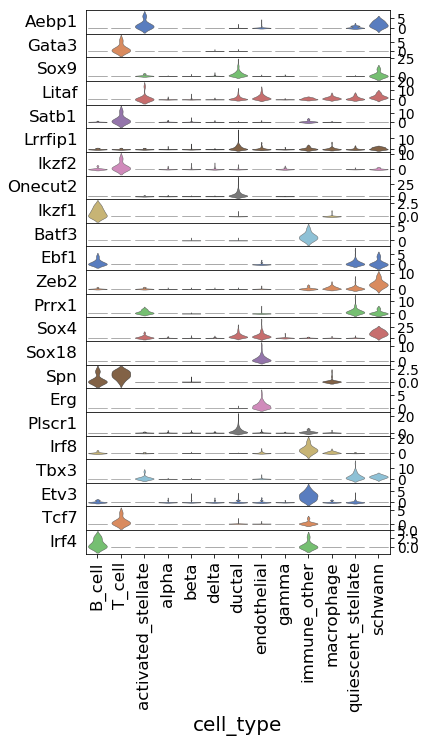

In [ ]:
# RAT ISLET NON_ENDOCRINE ISLET CELL MARKERS - SELECTED

INGAP_markers = ['Irf4', 'Irf8', 'Spn', 'Gata3', 'Ikzf1', 'Ikzf2', 'Satb1', 'Tcf7', 'Erg', 'Sox18', 'Batf3', 'Etv3', 'Prrx1', 'Ebf1', 'Tbx3', 'Aebp1', 'Litaf', 'Zeb2', 'Onecut2', 'Lrrfip1', 'Plscr1', 'Sox4', 'Sox9']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(adata_Baron.var_names) & set(INGAP_markers))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,10), save=('INGAP_POTENCIAL_CONTAMINATION_markers_TF_Selected'))




saving figure to file ./figures/stacked_violinINGAP_PCA3_Ctrl_9-16_vs_Ctrl_11_18.pdf


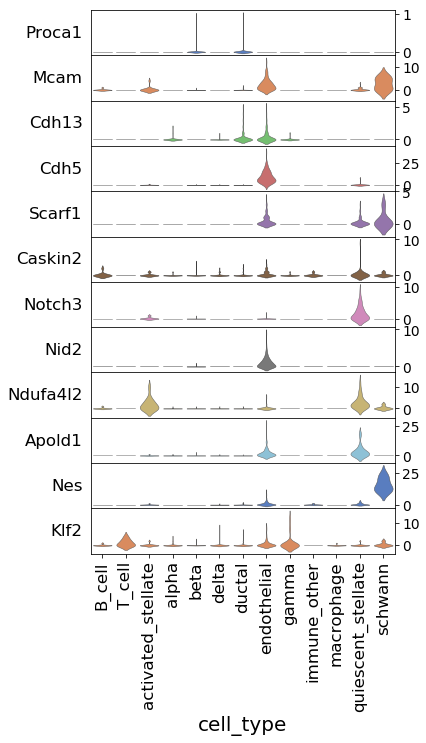

In [ ]:
# RAT ISLET PCA3 CTRL9-16 VS CTRL11-18

INGAP_markers = ['Proca1', 'Scarf1', 'Mcam', 'Nid2', 'RGD1305807', 'LOC108351723', 'Caskin2', 'Apold1', 'LOC100910973', 'LOC103693764', 'Klf2', 'LOC108351660', 'Hist2h2ab', 'Nes', 'Ndufa4l2', 'Cdh5', 'Tp53i11', 'Notch3', 'LOC108348208', 'Cdh13']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(INGAP_markers) & set(adata_Baron.var_names))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,10), save=('INGAP_PCA3_Ctrl_9-16_vs_Ctrl_11_18'))




saving figure to file ./figures/stacked_violinINGAP_PCA1_Ctrl_9-11_vs_Ctrl_16_18_SEQ_DAY_MARKERS_UP_SELECTED.pdf


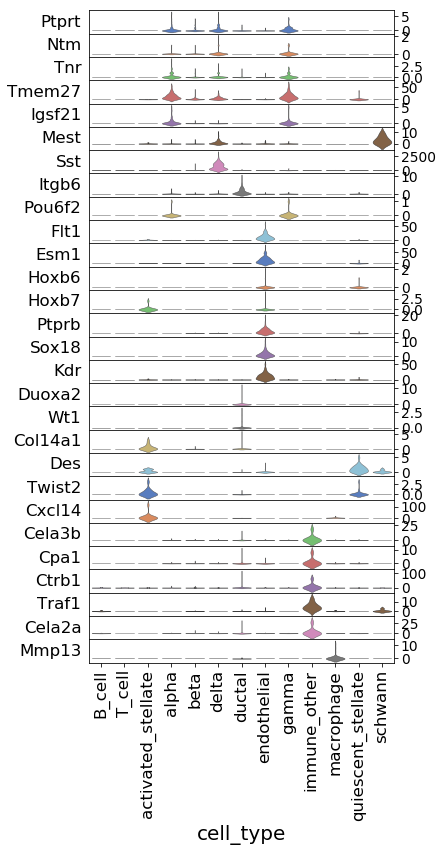

In [ ]:
# RAT ISLET PCA1 CTRL9-11 VS CTRL16-18 - SEQ DAY MARKERS!!!

INGAP_markers = ['Rn7sl1', 'LOC100365810', 'LOC100362366', 'Rmrp', 'RGD1305733', 'Syt12', 'Batf2', 'Lmo1', 'Aif1', 'Ghrl', 'LOC102549750', 'Ptges', 'Dpt', 'Clcn4', 'LOC108352650', 'LOC100360841', 'LOC103693330', 'LOC108352861', 'Lamp5', 'LOC103694585']

INGAP_markers = ['Fga', 'Cartpt', 'Apob', 'LOC108352353', 'Itih3', 'Ctrb1', 'Pcsk9', 'LOC681458', 'Ropn1l', 'LOC108351746', 'Hbb', 'Hba1', 'Cela2a', 'Sycn', 'Reg1a', 'Prss1', 'LOC103689940', 'Cpa1', 'Cela3b', 'Bpifa2f']

INGAP_markers = ['Syt12', 'Batf2', 'Lmo1', 'Aif1', 'Ghrl', 'Ptges', 'Dpt', 'Clcn4', 'Lamp5', 'Slc39a8', 'Angptl4', 'Lin7b', 'Mt1', 'Spp2', 'Dbp', 'Rps21']

INGAP_markers = ['LOC681458', 'Ropn1l', 'LOC108351746', 'Hbb', 'Hba1', 'Cela2a', 'Sycn', 'Reg1a', 'Prss1', 'LOC103689940', 'Cpa1', 'Cela3b', 'Bpifa2f', 'Pcsk9', 'Ctrb1', 'Itih3', 'LOC108352353', 'Apob', 'Cartpt', 'Fga', 'P2rx2', 'Ranbp3l', 'Chp2', 'Gpr83', 'Fgb', 'Pla2g1b', 'Mug1', 'Scd', 'Ak8', 'LOC103691961', 'Fgg', 'Cacng6', 'Esm1', 'Smgc', 'LOC102549404', 'Cntnap5c', 'Nptx1', 'Cpa2', 'LOC108352182', 'Spock1', 'Kcnk2', 'Trh', 'LOC679818', 'Gabrg2', 'Prokr2', 'Gucy2c', 'LOC100909521', 'Insig1', 'LOC108352534', 'Ros1', 'Rit2', 'C2cd4a', 'Gad1', 'Lipg', 'Sema3d', 'C2cd4b', 'Elmo1', 'Cxcl14', 'LOC100912336', 'LOC108351541', 'Idi1', 'Hoxb6', 'Lingo2', 'Stc1', 'Hmgcs1', 'F2', 'LOC108351262', 'Tnr', 'Igfbp5', 'Vnn1', 'Taar1', 'LOC100910084', 'Eppk1', 'Vwce', 'Pcp4l1', 'Mest', 'LOC108351374', 'Prelp', 'Itih1', 'LOC108350694', 'Avpr1b', 'Vgf', 'Cox4i2', 'Trpa1', 'Trim72', 'Pyy', 'Kcna5', 'Sst', 'Npas2', 'Mmp13', 'Kcnk16', 'Tpbgl', 'Serpina3n', 'Msmo1', 'Smoc1', 'Hs3st6', 'Ddah1', 'Bche', 'Aadat', 'Twist2', 'Thbd', 'Gng7', 'Pla2g4e', 'Gpr88', 'Gnat3', 'Rerg', 'Olfml2a', 'Pou3f4', 'Susd5', 'Scd2', 'Lypd6', 'Slc26a5', 'Ptprt', 'Sik1', 'Ahnak2', 'Ryr2', 'Tmem255b', 'Hoxb7', 'Atp2b4', 'Oas3', 'Scml4', 'Slc38a5', 'Chst15', 'Lama3', 'Ksr2', 'Nrtn', 'Hpx', 'Col14a1', 'Osbp2', 'Dnah9', 'Stc2', 'Gng2', 'Gp2', 'Necab1', 'Epha5', 'LOC103693564', 'Igsf21', 'Acat2', 'Kif26a', 'Kcnma1', 'LOC689986', 'Fbxl7', 'Pou6f2', 'Afm', 'Plagl1', 'LOC102546369', 'Klf5', 'Gas1', 'LOC108349107', 'Chst5', 'Fgf1', 'Dhcr24', 'Gpr20', 'Ntm', 'Wnk3', 'Ffar2', 'LOC102552055', 'Flt1', 'Igfals', 'Tiam1', 'Tbx3', 'Dcx', 'A1cf', 'Il23r', 'Duoxa2', 'Cntnap2', 'Sema6a', 'Slc38a3', 'Lingo3', 'Clmp', 'Traf1', 'Cyp51', 'LOC103689964', 'Fam167a', 'Wt1', 'Gpr142', 'Proc', 'LOC102553528', 'LOC685716', 'Tff3', 'C4bpb', 'Il22ra1', 'Ak4', 'RGD1564308', 'Sdk2', 'Rnf125', 'Igfbp4', 'Hoxb5', 'Plet1', 'Ndst4', 'Prlr', 'Gpr161', 'Foxc2', 'Kcnh1', 'Egln3', 'LOC100909524', 'Fblim1', 'Spry4', 'LOC108348154', 'Apc2', 'Slit1', 'Hoxb3', 'Hsd17b7', 'LOC102547797', 'Epha8', 'Irs2', 'Itgb6', 'Mgat5', 'Smim1', 'Dusp5', 'Plekhb1', 'Timp3', 'Klf8', 'Rnf182', 'Wnt5a', 'Myo15a', 'Pam', 'Fam46a', 'Ace2', 'Dll4', 'Pim2', 'Dnah8', 'Tmprss2', 'Agt', 'Myo16', 'Kcnq2', 'Aqp1', 'Gja1', 'Zim1', 'Prr15l', 'Tns1', 'LOC103692551', 'Klk1c9', 'Ccnyl1', 'Abcc9', 'LOC680875', 'Slc8a3', 'Igfbp7', 'Fasn', 'Lrrc32', 'Tmem27', 'Cacna1h', 'Ptprm', 'Ckb', 'Kdr', 'Car2', 'Chn2', 'Egflam', 'Tln2', 'Bfsp1', 'Ldlr', 'Hey1', 'Gap43', 'Tmem229a', 'Baalc', 'Hmgcr', 'Fdps', 'Npy1r', 'Abhd15', 'Rab3b', 'Serpina10', 'LOC103691888', 'Chdh', 'Liph', 'Prickle2', 'LOC102551453', 'Npy', 'Rgma', 'Des', 'LOC100911068', 'LOC108350375', 'Sh3pxd2b', 'Phkg1', 'Dclk3', 'LOC100909582', 'Ptprb', 'LOC108349805', 'Ntn4', 'Sox18']

INGAP_markers = ['Ptprt', 'Ntm', 'Tnr', 'Tmem27', 'Igsf21', 'Mest', 'Sst', 'Itgb6', 'Pou6f2', 'Flt1', 'Esm1', 'Hoxb6', 'Hoxb7', 'Ptprb', 'Sox18', 'Kdr', 'Duoxa2', 'Wt1', 'Col14a1', 'Des', 'Twist2', 'Cxcl14', 'Cela3b', 'Cpa1', 'Ctrb1', 'Traf1', 'Cela2a', 'Mmp13']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
# INGAP_markers = list(set(INGAP_markers) & set(adata_Baron.var_names))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,12), save=('INGAP_PCA1_Ctrl_9-11_vs_Ctrl_16_18_SEQ_DAY_MARKERS_UP_SELECTED'))




saving figure to file ./figures/stacked_violinINGAP_Marcadores_Agustin.pdf


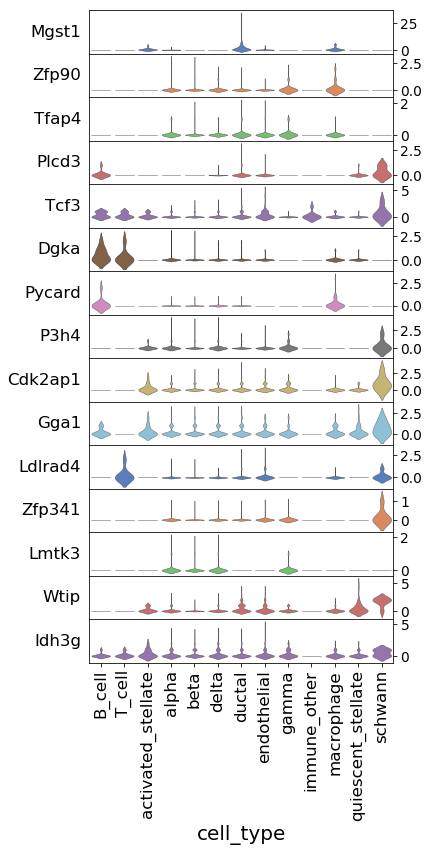

In [ ]:
# RAT ISLET PCA1 CTRL9-11 VS CTRL16-18 - SEQ DAY MARKERS!!!

INGAP_markers = ['Zfp341', 'Mgst1', 'Msc', 'Dgka', 'Tcf3', 'Pycard', 'Gga1', 'Idh3g', 'Tfap4', 'P3h4', 'Plcd3', 'Cdk2ap1', 'Wtip', 'Ldlrad4', 'Lmtk3', 'Zfp90']

# Here we filter our list to keep only those gene names that are found within the
# gene names of the Baron et al dataset:
INGAP_markers = list(set(INGAP_markers) & set(adata_Baron.var_names))

# produce violin plots to visualize the gene expression profiles across cell types
matplotlib.rcParams.update({'font.size': 20})
sc.pl.stacked_violin(adata_Baron, INGAP_markers, groupby='cell_type', rotation=90,
                     swap_axes=True, figsize=(6,12), save=('INGAP_Marcadores_Agustin'))




In [ ]:
# This function was downloaded from:
# https://github.com/theislab/scanpy/issues/290

# Define cluster score for individual genes
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """
    A function to get mean z-score expressions of marker genes
    #
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1'
    """

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    #Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

In [ ]:
# ACA TENDRIAMOS QUE ENCOTRAR UNA FORMA DE HACER ANDAR ESTA FUNCION

# EL OBJETIVO ES TENER UN Z SCORE PARA CADA GEN, POR TIPO CELULAR
# SI MIRAS LOS VIOLIN PLOTS DE MAS ARRIBA, LA IDEA SERIA QUE:
# "TTR" TENDRIA QUE TENER UN SCORE MUY ALTO UNICAMENTE PARA CELULAS ALPHA
# "NKX6-1" TENDRIA QUE TENER UN SCORE MUY ALTO PARA CELULAS BETA, UN BASTANTE MAS BAJO PARA CELULAS GAMMA
# "ADAMTS3" TENDRIA QUE TENER UN SCORE MAS ALTO PARA CELULAS STELLATE Y ENDOTELIALES

INGAP_markers = ['Msc', 'Plcd3', 'Casp6', 'Adamts7', 'P3h4', 'Tcf3', 'Pcif1', 'Ndts2', 'Hmmr', 'Mgat1',
                 'Pdx1', 'Fgfr4', 'Nkx6-1', 'Ttr', 'Cmip', 'Pcsk1n']

# NO ESTOY SEGURO DE ESTO...
marker_dict = INGAP_markers

marker_gene_expression(adata_Baron, marker_dict, gene_symbol_key=None, partition_key='cell_type')

/home/santi/Programs/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:1043: RuntimeWarning: invalid value encountered in true_divide
  X /= scale


TypeError: list indices must be integers or slices, not str